In [2]:
import string
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import operator
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import time
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_breast_cancer
from id3 import Id3Estimator,export_text
from id3 import export_graphviz
from sklearn import metrics

C:\Users\aggloupas\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
# define function for feature list
def get_feature(df, number):
    
    feature_list = []
    # create an instance for feature selection
    tree_clf = ExtraTreesClassifier()

    # first create arrays holding input and output data

    # Vectorizing Train set
    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['review'])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df['label'])

    # fit the model
    tree_clf.fit(x_train, y)
    
    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Create the feature list
    for f in range(number):
        feature_list.append(sorted_features[f][0])
    
    return(feature_list)

In [5]:
#define stopwords-stemmer & lemmatizing
stop = stopwords.words('english')
stemmer = SnowballStemmer("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

In [6]:
#Importing dataset
filepath = r'C:\Users\aggloupas\Desktop\MSc\Εξόρυξη Δεδομένων και Προβλεπτική Αναλυτική\Χαλκίδη\imdb_master.csv'

In [7]:
#-----------Preprocess-----------------
#define objectrs & splitting dataset to train set, test set & unsupported reviews
dfcsv = pd.read_csv(filepath, sep=',' ,skip_blank_lines=True, error_bad_lines=False , engine='python')
df_trainset = dfcsv.query( 'label != "unsup" & type =="train"')
df_test = dfcsv.query('type == "test"').sample(n=1000, axis=None)
df_unsup = dfcsv.query('label == "unsup"')#.sample(n=1000, axis=None)

In [8]:
#choose 1250 negative & 1250 positive reviews for train set
dfn = df_trainset.query('label =="neg"').sample(n=1250, axis=None)
dfp = df_trainset.query('label =="pos"').sample(n=1250, axis=None)
df_25 = pd.concat([dfn, dfp], ignore_index=True)

In [9]:
#cleaning data set
df_25['review'] = df_25['review'].str.replace('[^\w\s]',' ').str.findall('\w{3,}').str.join(' ').str.replace('\d+', ' ').str.lower().apply(lambda x: [item for item in str(x).split() if item not in stop])
df_test['review'] = df_test['review'].str.replace('[^\w\s]',' ').str.findall('\w{3,}').str.join(' ').str.replace('\d+', ' ').str.lower().apply(lambda x: [item for item in str(x).split() if item not in stop])

In [10]:
#Snowball_Stemmer
df_test['review'] = df_test['review'].apply(lambda x: [stemmer.stem(y) for y in x])
df_25['review'] = df_25['review'].apply(lambda x: [stemmer.stem(y) for y in x])

In [11]:
#Lemmatizer
df_test['review'] = df_test['review'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df_25['review'] = df_25['review'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [12]:
#concat train &test set to get infos about reviews
df_all = pd.concat([df_25, df_test], ignore_index=True)
df_all['review'] = df_all['review'].str.join(' ') # Tokenized words to document

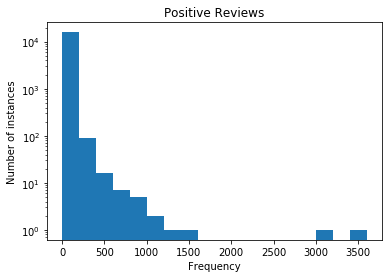

In [13]:
#Histogram Positive dataset post feature selection 

# Create an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
hist_pos = hist_cv.fit_transform(df_all[df_all.label.isin(['pos'])].review)

# Visualising the histogram for positive reviews only from train and dataset
data = hist_pos.sum(axis=0).tolist()
binwidth = 200
plt.hist(data, bins=range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Positive Reviews")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

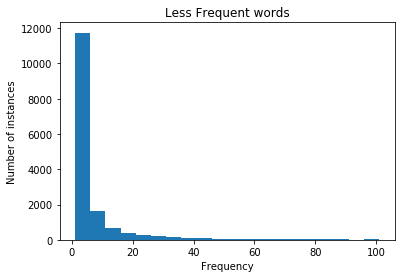

In [14]:
#Histogram of positive words that have less than 100 frequency rate

zoom_data = [f for f in data[0] if f <= 100]
binwidth = 5
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=False)
plt.title("Less Frequent words")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

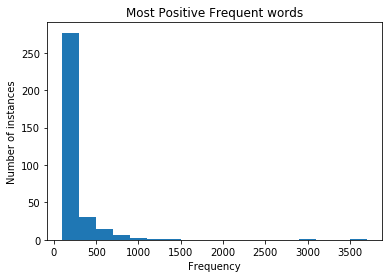

In [15]:
#Histogram of positive words that have more than 100 frequency rate

zoom_data = [f for f in data[0] if f > 100]
binwidth = 200
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=False)
plt.title("Most Positive Frequent words")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

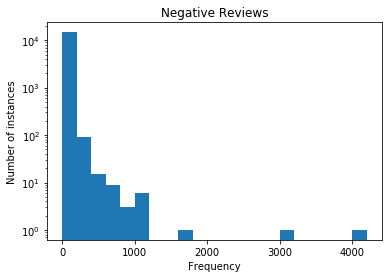

In [16]:
#Histogram Negative dataset post feature selection 

# Creating an object for Count vectorizer and fitting it to positive dataset
hist_cv = CountVectorizer(stop_words = 'english', analyzer='word')
hist_pos = hist_cv.fit_transform(df_all[df_all.label.isin(['neg'])].review)

# Visualising the histogram for negative reviews only from train and dataset
data = hist_pos.sum(axis=0).tolist()
binwidth = 200
plt.hist(data, bins=range(min(data[0]), max(data[0]) + binwidth, binwidth), log=True)
plt.title("Negative Reviews")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

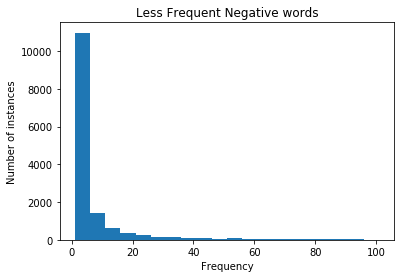

In [17]:
#Histogram of negative words that have less than 100 frequency rate
zoom_data = [f for f in data[0] if f <= 100]
binwidth = 5
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=False)
plt.title("Less Frequent Negative words")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

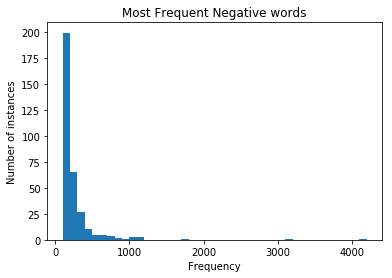

In [18]:
#Histogram of negative words that have more than 100 frequency rate

zoom_data = [f for f in data[0] if f > 100]
binwidth = 100
plt.hist(zoom_data, bins=range(min(zoom_data), max(zoom_data) + binwidth, binwidth), log=False)
plt.title("Most Frequent Negative words")
plt.xlabel("Frequency")
plt.ylabel("Number of instances")
plt.show()

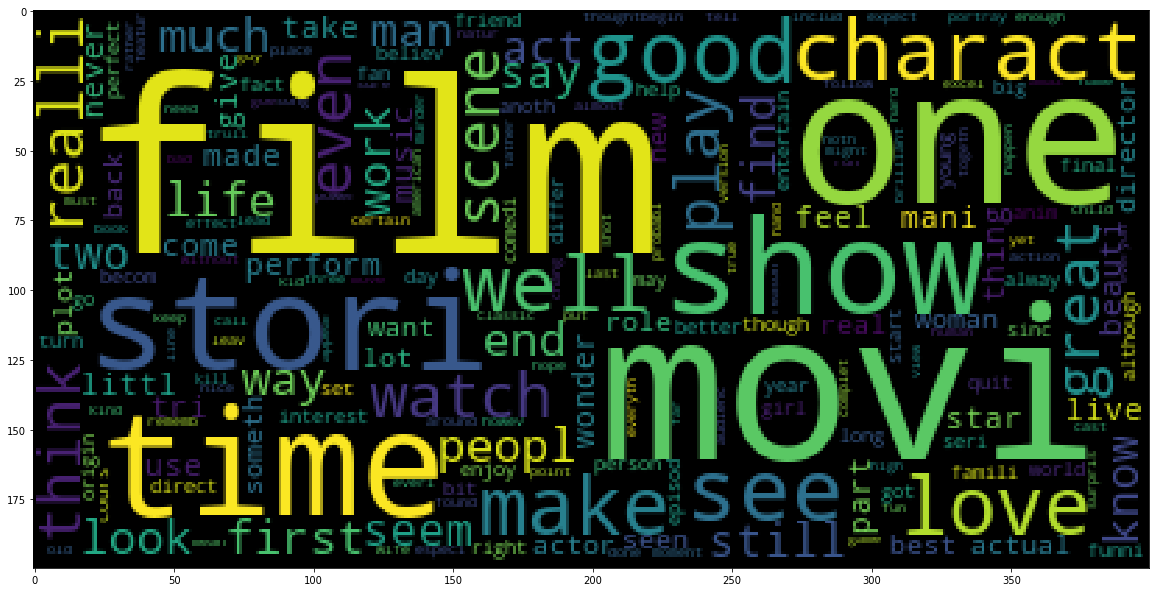

In [19]:
#visualization of positive reviews from both of train & test data

imdb_list = df_all["review"][df_all.label.isin(['pos'])].unique().tolist()
imdb_bow = " ".join(imdb_list)
from wordcloud import WordCloud
# Create a word cloud for psitive words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

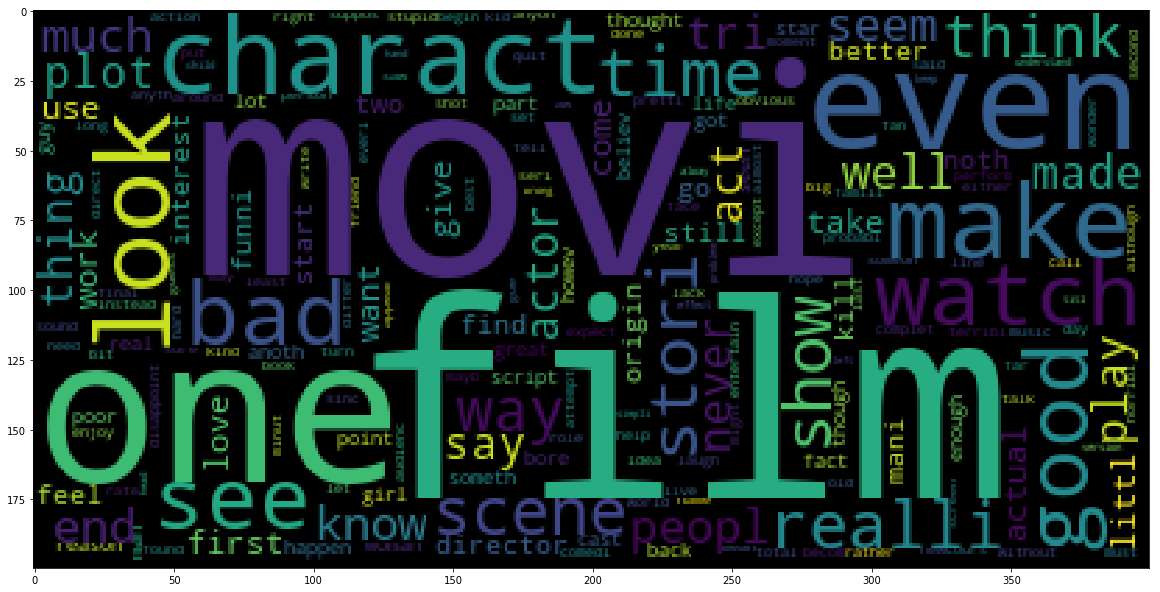

In [20]:
#visualization of negative reviews from both of train & test data

# Creating a list of ham data only to analyse
imdb_list = df_all["review"][df_all.label.isin(['neg'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud 
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

C:\Users\aggloupas\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\aggloupas\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\aggloupas\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



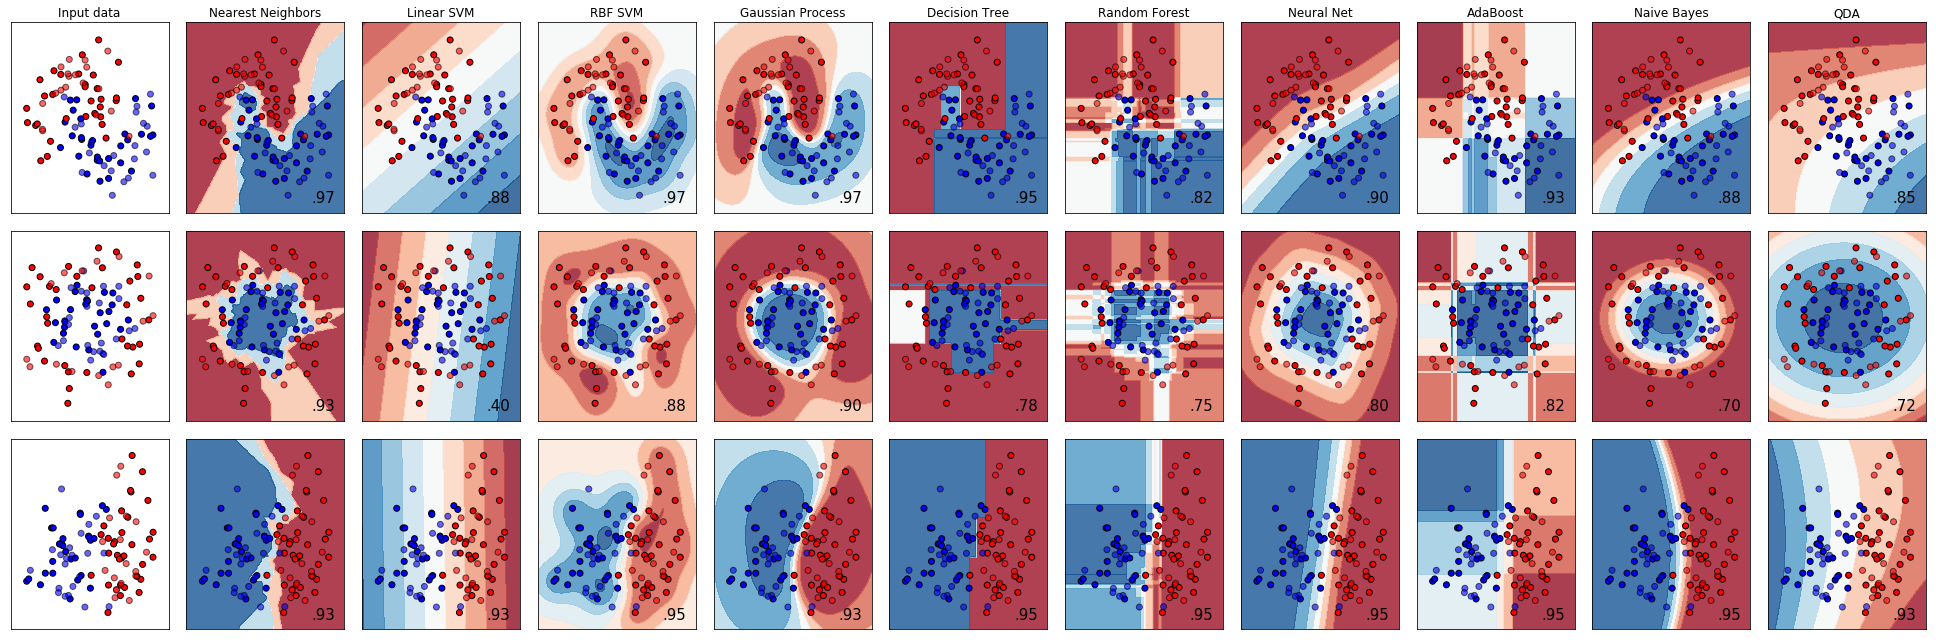

In [21]:
#Benchmark of various classifiers

#importing libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#Create optical Benchmark

h = .02  # step size in the mesh

#set names
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

#Classifiers
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

#adding noise
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1

# iterate over datasets
ds = df_all
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test 
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [22]:
#Preparing dataframe for model 

# Creating df_algo dataframe which will be used for hypothesis testing
df_algo = pd.concat([df_25, df_test], keys=['train', 'test'])
df_algo = df_algo.reset_index(col_level=1).drop(['level_1'], axis=1)


df_algo['review'] = df_algo['review'].str.join(' ') #tokenize words to document


# Removing non feature words 

# feature word_list
word_list = get_feature(df_algo[['review', 'label']], 3500) # Select words from both of train & test data


#Splitting with feature selection data 

# Vectorising selected data
vect_algo = TfidfVectorizer(stop_words='english', analyzer='word')
vect_algo.fit(df_algo.review)
Xf_train = vect_algo.transform(df_algo[df_algo['level_0'].isin(['train'])].review)
Xf_test = vect_algo.transform(df_algo[df_algo['level_0'].isin(['test'])].review)

# Encoding target data

le = LabelEncoder()# Creating an object and fitting on target strings
#split data to train & test
yf_train = le.fit_transform(df_algo[df_algo['level_0'].isin(['train'])].label)
yf_test = le.fit_transform(df_algo[df_algo['level_0'].isin(['test'])].label)


#Apply Algorithms to data

#KNN

# instantiate learning model (k = 3)
knn_start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=3)
 # fitting the model
knn.fit(Xf_train, yf_train)
# predict the response
pred = knn.predict(Xf_test)
knn_proc_time = (time.time() - knn_start_time)
# evaluate accuracy
knn_acc = accuracy_score(yf_test, pred)


#SVC

svc_start_time = time.time()
clf = svm.SVC(kernel='linear', C = 1)
clf.fit(Xf_train, yf_train)
predsvc = clf.predict(Xf_test)
svc_proc_time = (time.time() - svc_start_time)
svc_acc = accuracy_score(yf_test, predsvc)

#DecisionTreeClassifier

dtree_start_time = time.time()
clf_dt = tree.DecisionTreeClassifier()
clf_dt = clf_dt.fit(Xf_train, yf_train)
preddt = clf_dt.predict(Xf_test)
dtree_proc_time = (time.time() - dtree_start_time)
dtree_acc = accuracy_score(yf_test, preddt)

#_NaiveB

nb_start_time = time.time()
clf_nb = MultinomialNB()
clf_nb.fit(Xf_train, yf_train)
# predict the outcome for testing data
predictions = clf_nb.predict(Xf_test)
# check the accuracy of the model
nb_proc_time = (time.time() - nb_start_time)
nb_acc = accuracy_score(yf_test, predictions)



In [23]:
# Vectorizing pos reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_algo[df_algo.label.isin(['pos'])].review)

# Visualising the high frequency words for positive set
df_test_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_test_freq.nlargest(10, 'frequency')

,frequency
film,3595
movi,3065
like,1455
time,1216
good,1064
stori,1022
make,969
watch,893
love,892
great,878


In [24]:
# Vectorizing negative reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_neg = vect.fit_transform(df_algo[df_algo.label.isin(['neg'])].review)

# Visualising the high frequency words for negative set
df_test_freq = pd.DataFrame(vect_neg.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_test_freq.nlargest(10, 'frequency')

,frequency
movi,4122
film,3150
like,1705
bad,1164
make,1155
watch,1110
time,1090
charact,1024
good,1024
realli,956


In [25]:
#create table for validation of classifiers
df_knn = ["knn", knn_acc,knn_proc_time]
df_svc = ["svc", svc_acc,svc_proc_time]
df_dtree = ["dtree", dtree_acc,dtree_proc_time]
df_nb = ["nb", nb_acc,nb_proc_time]
frames = [df_knn, df_svc, df_dtree, df_nb]
results = pd.DataFrame(data=frames)
results.columns = ['classifier','score','proc_time']
#df1.query( 'classifier == "Nearest Neighbors"')
results.groupby(['classifier']).mean()

,score,proc_time
classifier,,
dtree,0.691,1.167917
knn,0.645,0.197458
nb,0.814,0.006983
svc,0.831,6.772860
